In [168]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.random import generate_standard_normal
from torchlake.image_generation.models.gan import GANDiscriminator, GANGenerator
from torchvision import transforms
from tqdm import tqdm

# Setting

In [169]:
IMAGE_SIZE = 32
BATCH_SIZE = 128

In [170]:
artifact_path = Path("../../artifacts/gan")
data_path = Path("../../data/fashionMnist")

In [171]:
DEVICE = torch.device("cuda:0")

# Data

In [172]:
preprocess = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)

In [173]:
train_data = torchvision.datasets.FashionMNIST(
    root=data_path.as_posix(),
    train=True,
    transform=preprocess,
    download=True,
)

In [174]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

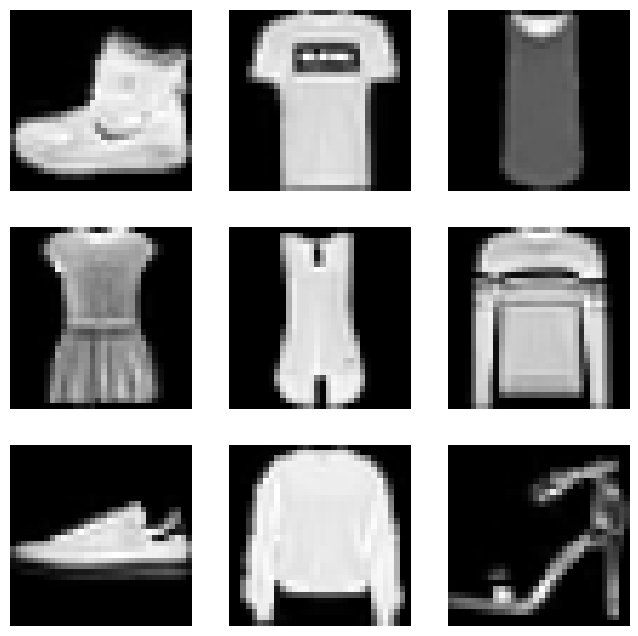

In [175]:
# 資料集繪圖
plot_grids(
    [*img_tensor_to_np(torch.stack([train_data[i][0] for i in range(9)]))],
    num_row=3,
    num_col=3,
    cmap="gray",
)

# train

In [176]:
LATENT_DIM = 128
HIDDEN_DIM = 256

In [177]:
generator = GANGenerator(
    LATENT_DIM,
    HIDDEN_DIM,
    (1, IMAGE_SIZE, IMAGE_SIZE),
).to(DEVICE)
discriminator = GANDiscriminator(
    HIDDEN_DIM,
    (1, IMAGE_SIZE, IMAGE_SIZE),
    dropout_prob=0,
).to(DEVICE)

In [178]:
LR = 1e-4
BETA = (0.5, 0.999)

In [179]:
criterion = nn.BCEWithLogitsLoss(reduction="mean")
optim_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=BETA)
optim_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=BETA)

In [180]:
EPOCH = 10

In [181]:
N = len(train_data)

for e in range(EPOCH):
    running_loss_G = 0.0
    running_loss_D = 0.0

    for img, _ in tqdm(train_loader):
        img = img.to(DEVICE)

        valid = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake = torch.zeros(BATCH_SIZE, 1).to(DEVICE)


        discriminator.train()
        generator.eval()
        optim_D.zero_grad()
        noise = generate_standard_normal(BATCH_SIZE, LATENT_DIM).to(DEVICE)
        gen_img = generator(noise)
        real_loss = criterion(discriminator(img), valid)
        fake_loss = criterion(discriminator(gen_img.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optim_D.step()
        running_loss_D += d_loss.item()

        generator.train()
        discriminator.eval()
        optim_G.zero_grad()
        noise = generate_standard_normal(BATCH_SIZE, LATENT_DIM).to(DEVICE)
        gen_img = generator(noise)
        g_loss = -criterion(discriminator(gen_img), fake)
        g_loss.backward()
        optim_G.step()
        running_loss_G += g_loss.item()

    print(
        f"epoch {e+1}: D: {running_loss_D / N} G: {running_loss_G / N}"
    )

100%|██████████| 468/468 [00:20<00:00, 22.47it/s]


epoch 1: D: 0.005034647437930107 G: -0.004951300987104575


100%|██████████| 468/468 [00:20<00:00, 22.64it/s]


epoch 2: D: 0.0039023838510115942 G: -0.0032075777404010296


100%|██████████| 468/468 [00:20<00:00, 22.79it/s]


epoch 3: D: 0.0031538593555490175 G: -0.002468400735159715


100%|██████████| 468/468 [00:20<00:00, 22.81it/s]


epoch 4: D: 0.0027937244315942127 G: -0.002122336939473947


100%|██████████| 468/468 [00:20<00:00, 22.71it/s]


epoch 5: D: 0.002518512856463591 G: -0.0018967731631050508


100%|██████████| 468/468 [00:20<00:00, 22.74it/s]


epoch 6: D: 0.0023794702852765717 G: -0.001756881103788813


100%|██████████| 468/468 [00:20<00:00, 22.81it/s]


epoch 7: D: 0.002246934007356564 G: -0.00160069568430384


100%|██████████| 468/468 [00:21<00:00, 21.77it/s]


epoch 8: D: 0.002106369558721781 G: -0.001447244114925464


100%|██████████| 468/468 [00:21<00:00, 22.07it/s]


epoch 9: D: 0.002084743698189656 G: -0.0015182445064807933


100%|██████████| 468/468 [00:21<00:00, 22.15it/s]

epoch 10: D: 0.001941410071651141 G: -0.0013248717065279683


# evaluation

In [182]:
# 區別是否為真實圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, _ in tqdm(train_loader):
        img = img.to(DEVICE)
        hits += discriminator(img).sigmoid().gt(0.5).sum().item()

    print(hits / len(train_data))

100%|██████████| 468/468 [00:11<00:00, 39.11it/s]

0.8263333333333334


In [183]:
# 區別是否為合成圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, label in tqdm(train_loader):
        noise = generate_standard_normal(BATCH_SIZE, LATENT_DIM).to(DEVICE)
        gen_img = generator(noise)
        hits += discriminator(gen_img).sigmoid().gt(0.5).sum().item()
    print(hits / len(train_data))

100%|██████████| 468/468 [00:12<00:00, 38.04it/s]

0.03133333333333333


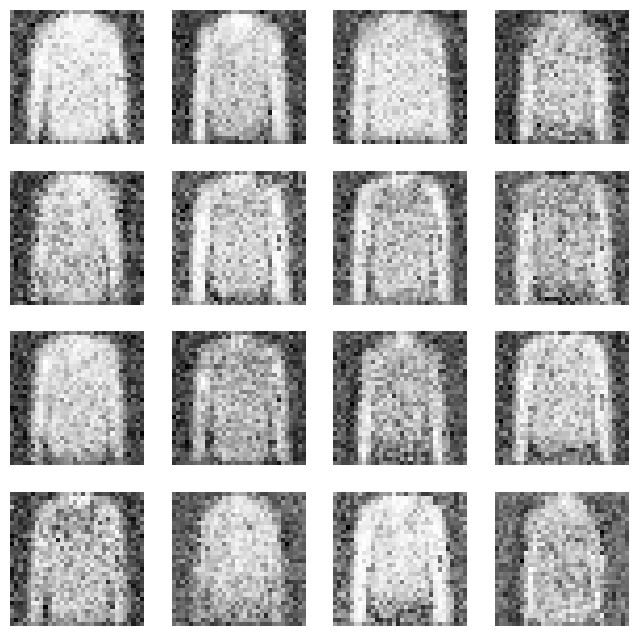

In [184]:
# 合成圖片
generator.eval()
with torch.no_grad():
    noise = generate_standard_normal(16, 128).to(DEVICE)
    gen_img = generator(noise)
    
    plot_grids(
        img_tensor_to_np(gen_img),
        num_row=4,
        num_col=4,
        is_gray_scale=True,
    )

In [34]:
model_path = artifact_path / 'gan.pth'

In [35]:
torch.save(generator.state_dict(), model_path.as_posix())

In [ ]:
generator.load_state_dict(torch.load(model_path.as_posix()))